<strong><u> Multiclass TextClassification model for predictive maintenance using info/error/warning messages from log files </strong></u>

 * This model is capable of predicting 27 different error messages using system log file messages
 * Applied bag-of-words (BOW) and TF-IDF feature extraction techniques to convert text to vector representation
 * Used a 5-min window of system log text messages prior to an error event
 * In the 5-min interval, we only kept unique messages and dropped the duplicates
 * Applied additional text processing steps including 1. stemming 2. remove long and domain specific texts 3. Alpha Numeric  characters and 4. numbers replaced by a place holder

<u>Import necessary modules:</u>

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

<u>Load the data</u>

In [3]:
logstash = pd.read_excel('051723_Live_log_data.xlsx', sheet_name='LogStashLogs')
logstash['Date'] = pd.to_datetime(logstash.Date)
logstash['Date'] = logstash['Date'].dt.tz_convert(None)
logstash = logstash[logstash.Date.notnull()]
logstash = logstash.sort_values(['Date'], ascending=True)

<u> Exploratory data analysis </u>
    
* Count the occurance of error codes in the stash file logs

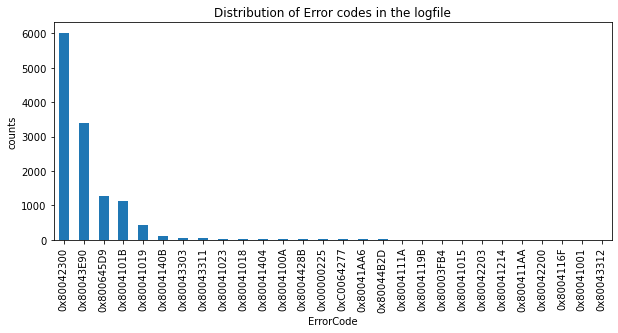

In [4]:
plt.figure(figsize=(10,4))
logstash.ErrorCode.value_counts().plot(kind='bar')
plt.xlabel('ErrorCode')
plt.ylabel('counts')
plt.title('Distribution of Error codes in the logfile')
plt.show()

* Frequency of the occurance of each error code within an interval of every hour

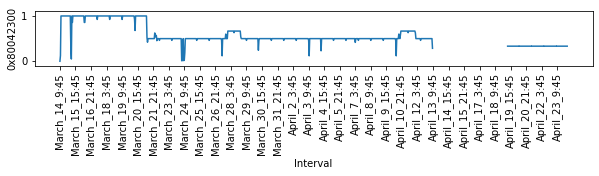

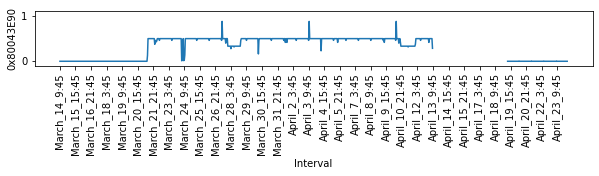

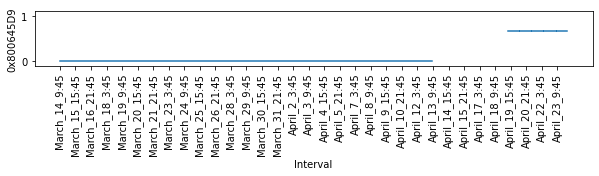

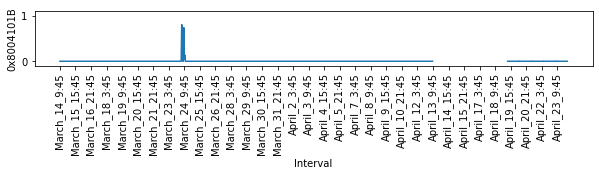

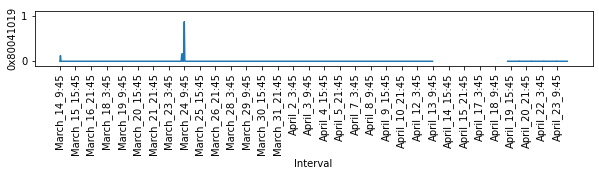

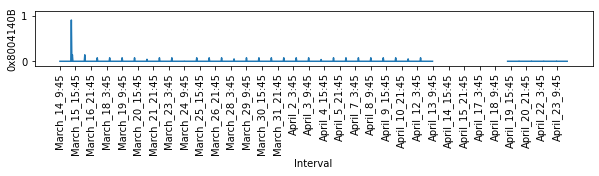

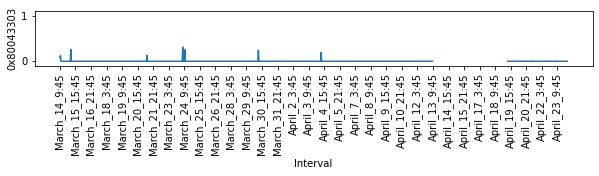

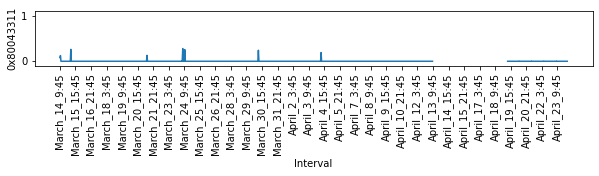

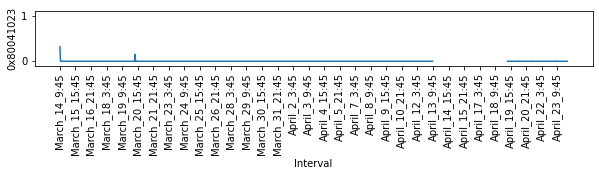

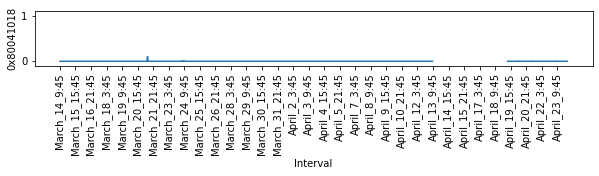

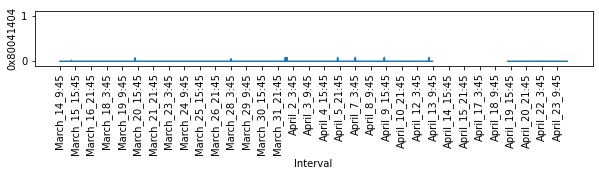

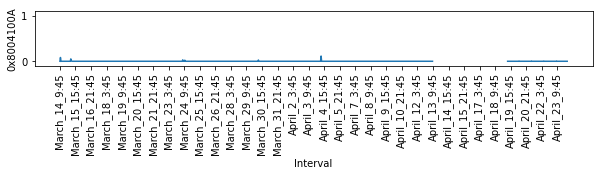

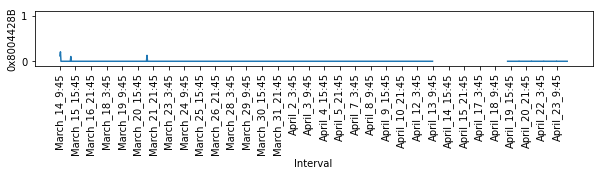

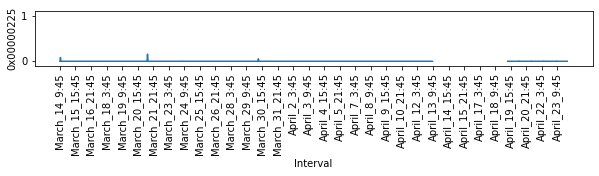

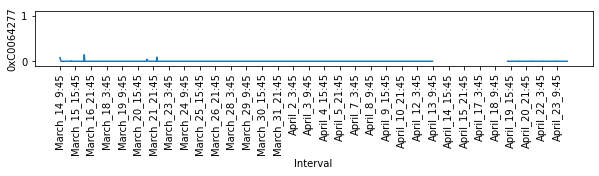

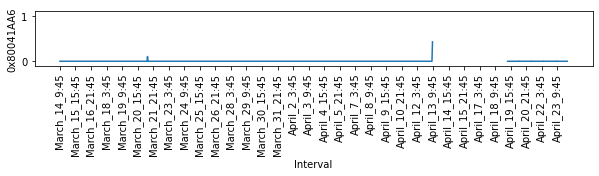

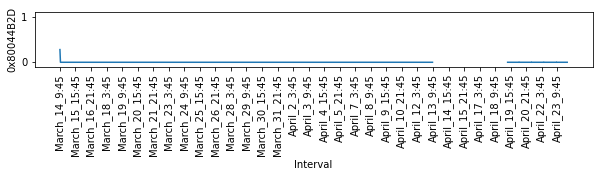

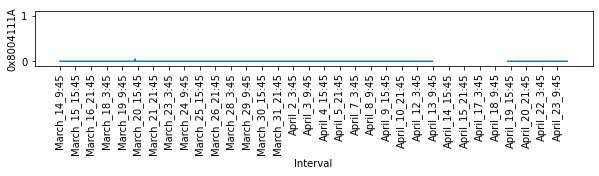

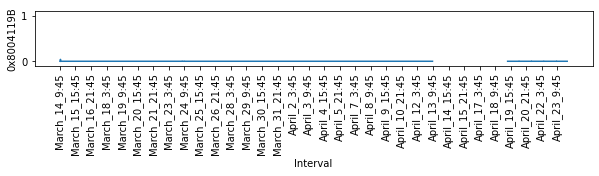

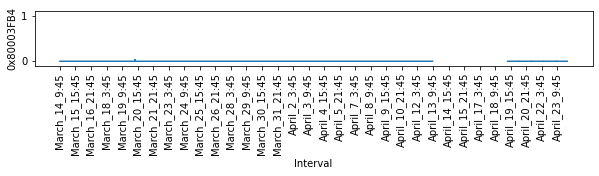

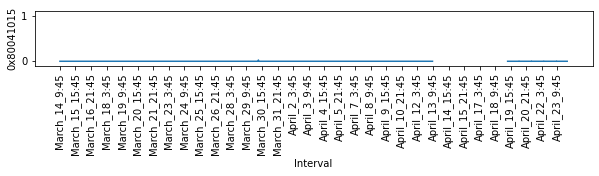

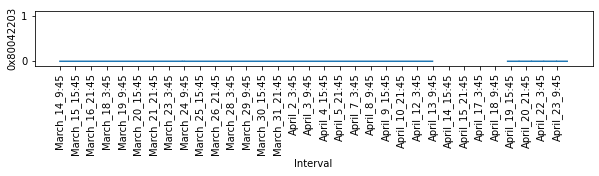

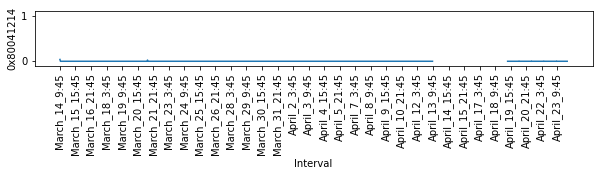

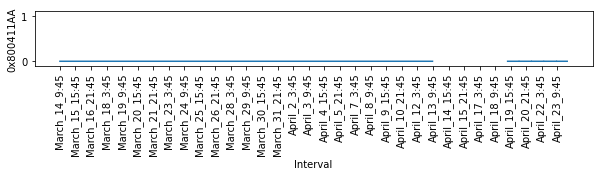

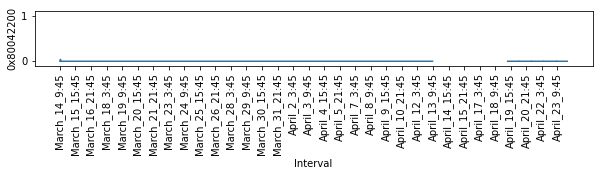

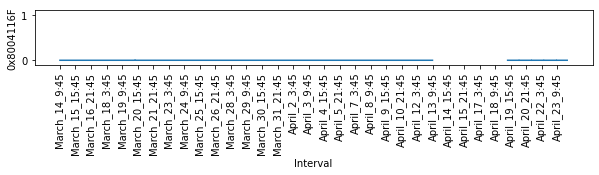

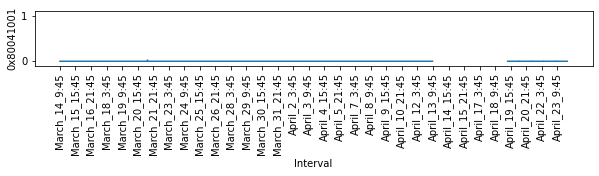

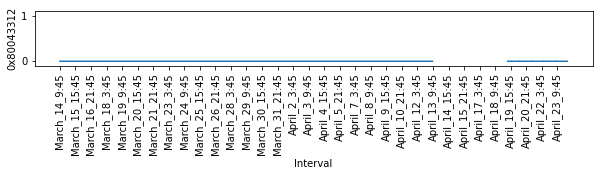

In [7]:
from datetime import datetime
import calendar

def convert_interval_to_date(string):
    datetimelist = []
    for i in range(len(string)):
        interval = string[i].strip("()").split(", ")
        date1 = datetime.strptime(interval[0], "%Y-%m-%d %H:%M:%S.%f")
        date2 = datetime.strptime(interval[0], "%Y-%m-%d %H:%M:%S.%f")
        calendar_month = calendar.month_name[date1.month]
        datetimelist.append(calendar_month + "_" + str(date1.day) + "_" + str(date1.hour) + ":"+ str(date1.minute))
    return datetimelist


logstash['Interval'] = pd.cut(logstash['Date'], 
                             bins=pd.date_range(start=logstash['Date'].iloc[0], 
                                               end=logstash['Date'].iloc[-1],
                                               freq='60 min'))  
count_df = logstash.groupby(['Interval', 'ErrorCode']).size().reset_index(name='count')

# Normalize the counts
norm_df = count_df.pivot(index='Interval', columns='ErrorCode', values='count').apply(lambda x: x / x.sum(), axis=1)
norm_df.index = norm_df.index.astype(str)

norm_df['monthhour'] = convert_interval_to_date(norm_df.index)

x_ticks = []
x_ticklabels = []
for i in range(0,len(norm_df),30):
    x_ticks.append(i)
    x_ticklabels.append(norm_df['monthhour'].iloc[i])


for col in logstash.ErrorCode.value_counts().index:
    plt.figure(figsize=(10,1))
    norm_df.loc[:, col].plot()
    plt.ylabel(col)
    plt.xticks(rotation=90)
    plt.xticks(x_ticks, x_ticklabels)
    plt.ylim(-0.1,1.1)
    plt.show()

In [8]:
logstash = logstash[logstash.Date <= pd.to_datetime('2023-04-14')]
logstash.tail()

,Srno,HostName,Type,ErrorCode,Date,Message,Interval
321501,321691,infovm-innovation,Info,NaN,2023-04-13 10:16:15.596,HTTPSenderThread starts_x000D_,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."
321502,321690,infovm-innovation,Error,NaN,2023-04-13 10:16:15.603,Server failed to start up due to the error: Th...,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."
321503,321692,infovm-innovation,Info,NaN,2023-04-13 10:16:15.606,HTTPSenderThread exits_x000D_,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."
321504,321694,infovm-innovation,Warning,NaN,2023-04-13 10:20:20.655,socket 1600 shutdown failed with error 10038_x...,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."
321505,321693,infovm-innovation,Error,NaN,2023-04-13 10:20:20.671,accept failed: 10038 on listener 1428_x000D_,"(2023-04-13 09:45:57.788000, 2023-04-13 10:45:..."


<u>Text preprocessing:</u>

In [9]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
def clean_text(text):
    text = text.lower()
    text = replace_by_space.sub(' ', text)
    text = bad_symbols.sub(' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    # remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # replace numbers with placeholder
    text = re.sub(r'\d+', 'NUM', text)
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]

    # perform stemming
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in filtered_words]

    # remove long and domain-specific words
    threshold = 15
    clean_words = [word for word in stemmed_words if len(word) <= threshold]

    # join the cleaned words back into a string
    cleaned_text = ' '.join(clean_words)
    
    return cleaned_text

round1 = lambda x: clean_text(x)

In [10]:
logstash['Message'] = logstash['Message'].apply(round1)

<u>Acquiring t-min window of system log text messages prior to each error event</u>

In [12]:
def get_info_before_errorcode(error_code, timedelta):
    timedelta = pd.Timedelta(str(timedelta) + ' minutes')
    matching_index = logstash[logstash.ErrorCode == error_code].index
    index_list = list(matching_index)
    
    error_code_info = {}
    error_code_info['ID'] = error_code
    occurance = []
    message = []
    count=0
    for index in index_list:
        start_date = str(logstash.loc[index, 'Date'] - timedelta)
        end_date = str(logstash.loc[index, 'Date'])
        chunk = logstash[(logstash.Date > start_date) & (logstash.Date <= end_date)]
        #chunk = chunk.drop_duplicates(subset='Message', keep='first')
        #chunk['Message'] = chunk['Message'].apply(round1)
        occurance.append(count)
        message.append(' '.join(chunk['Message']))
        count += 1
    error_code_info['occurance'] = occurance
    error_code_info['message'] = message
    error_code_info['logstash_index'] = index_list
    
    #result = pd.DataFrame.from_dict(error_code_info)
    return error_code_info

In [13]:
def get_info_before_errorcode_numlines(error_code, number_loglines):
    matching_index = logstash[logstash.ErrorCode == error_code].index
    index_list = list(matching_index)
    
    error_code_info = {}
    error_code_info['ID'] = error_code
    occurance = []
    message = []
    count=0
    for index in index_list:
        #chunk = logstash[(logstash.Date > start_date) & (logstash.Date <= end_date)]
        chunk = logstash.iloc[(index-number_loglines):index]
        #chunk = chunk.drop_duplicates(subset='Message', keep='first')
        #chunk['Message'] = chunk['Message'].apply(round1)
        occurance.append(count)
        message.append(' '.join(chunk['Message']))
        count += 1
    error_code_info['occurance'] = occurance
    error_code_info['message'] = message
    error_code_info['logstash_index'] = index_list
    
    #result = pd.DataFrame.from_dict(error_code_info)
    return error_code_info

In [14]:
import random
import pandas as pd
from tqdm import tqdm as tq

def check_overlap(time_blocks, block_start_time, block_end_time, max_overlap_time):
    check_items = []
    for overlap_index, overlap_item in enumerate(time_blocks):
        start_time = overlap_item[0]
        end_time = overlap_item[1]
        left_overlap = block_end_time - start_time
        right_overlap = end_time - block_start_time

        check = 0
        if (block_start_time <= start_time) and (block_end_time <= start_time):
            check = 1
        elif (block_start_time >= end_time) and (block_end_time >= end_time):
            check = 1
        elif (block_start_time <= start_time) and (left_overlap <= max_overlap_time):
            check = 1
        elif (block_end_time >= end_time) and (right_overlap <= max_overlap_time):
            check = 1

        check_items.append(check)
    if list(set(check_items))[0] == 1:
        time_blocks.append((block_start_time, block_end_time))

    return check_items, time_blocks

import numpy as np

def check_overlap_numpy(time_blocks, block_start_time, block_end_time, max_overlap_time):
    overlap_items = np.array(time_blocks)
    start_time = overlap_items[:, 0]
    end_time = overlap_items[:, 1]
    left_overlap = block_end_time - start_time
    right_overlap = end_time - block_start_time

    check = np.zeros(len(time_blocks), dtype=int)
    check[block_start_time <= start_time] = 1
    check[block_end_time >= end_time] = 1
    check[(block_start_time <= start_time) & (left_overlap <= max_overlap_time)] = 1
    check[(block_end_time >= end_time) & (right_overlap <= max_overlap_time)] = 1

    if np.any(check):
        time_blocks.append((block_start_time, block_end_time))

    return check.tolist(), time_blocks


def get_boundaries_for_noErrorCodes(timedelta, maxoverlap):
    timedelta = pd.Timedelta(str(timedelta) + ' minutes')
    errorcode_indices = logstash[logstash.ErrorCode.notnull()].index.sort_values(ascending=True)

    # pair of error codes that are at least (2 * timedelta + epsilon) apart.
    selective_indices = []
    for i in tq(range(len(errorcode_indices) - 1)):
        t1 = logstash.iloc[errorcode_indices[i]]['Date']
        t2 = logstash.iloc[errorcode_indices[i + 1]]['Date']
        time_diff = t2 - t1
        if time_diff >= 2 * timedelta + pd.Timedelta('30 sec'):
            selective_indices.append([errorcode_indices[i], errorcode_indices[i + 1]])

    #block_size = 5
    max_overlap_time = timedelta * maxoverlap 
    time_blocks = []

    # get the block of error messages that do not have labels
    for item_index, item in tq(enumerate(selective_indices)):
        start_time = logstash.iloc[item[0]]['Date']
        end_time = logstash.iloc[item[1]]['Date'] - timedelta

        num_trials = 0
        pbar = tq(total=100)
        while num_trials <= 100:
            block_start_time = start_time + pd.Timedelta(minutes=random.randint(0, int((end_time - start_time - timedelta).total_seconds() // 60)))
            block_end_time = block_start_time + timedelta
            if len(time_blocks) > 0:
                time_blocks_previous = len(time_blocks)
                check_items, time_blocks = check_overlap(time_blocks, block_start_time, block_end_time, max_overlap_time)
                time_blocks_updated = len(time_blocks)
                if time_blocks_updated > time_blocks_previous:
                    for block_index, block_item in enumerate(time_blocks):
                        block_start_time = block_item[0]
                        block_end_time = block_item[1]
                num_trials += 1
                pbar.update(1)
            else:
                time_blocks.append((block_start_time, block_end_time))
                pbar.update(1)
                for block_index, block_item in enumerate(time_blocks):
                    block_start_time = block_item[0]
                    block_end_time = block_item[1]

        pbar.close()
        if block_end_time >= end_time:
            break
    return time_blocks


def get_noErrorChunks(timedelta, maxoverlap):
    timeblocks = get_boundaries_for_noErrorCodes(timedelta, maxoverlap)
    count = 0
    error_code_info = {}
    error_code_info['ID'] = 'NoError'
    occurance = []
    message = []
    NoError_chunks = []
    for block_start_time, block_end_time in tq(timeblocks):
        #print(f"Selected time block: {block_start_time} to {block_end_time}")
        chunk = logstash[(logstash.Date > block_start_time) & (logstash.Date <= block_end_time)]
        chunk = chunk.drop_duplicates(subset='Message', keep='first')
        #chunk['Message'] = chunk['Message'].apply(round1)
        occurance.append(count)
        message.append(' '.join(chunk['Message']))
        count += 1
    error_code_info['occurance'] = occurance
    error_code_info['message'] = message
    error_code_info['logstash_index'] = 'NA'
    
    df = pd.DataFrame.from_dict(error_code_info)
    NoError_chunks.append(df)
    
    return NoError_chunks

In [16]:
errorcode_dict = dict(logstash['ErrorCode'].value_counts())
errorcode_list = [key for key, value in errorcode_dict.items()]

timedelta = 5 #minutes

ErrorChunks = []
for error_code in errorcode_list:
    df = pd.DataFrame.from_dict(get_info_before_errorcode(error_code, timedelta))
    ErrorChunks.append(df)
    
noErrorchunks = get_noErrorChunks(timedelta, 0.2)

#combining error and noError chunks
for i in noErrorchunks:
    ErrorChunks.append(i)
    
message_corpus = pd.concat(ErrorChunks)

100%|███████████████████████████████████████████████████████████████████████████| 10714/10714 [01:03<00:00, 167.78it/s]
0it [00:00, ?it/s]
102it [00:00, 3284.83it/s]                                                                                             

101it [00:00, 1384.76it/s]                                                                                             
2it [00:00, 14.11it/s]
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]
101it [00:00, 780.02it/s]                                                                                              

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]
101it [00:00, 915.41it/s]                                                                                              
4it [00:00,  9.11it/s]
  0%|                                                                                        

<u>Splitting the dataset</u>

In [17]:
X = message_corpus.message
y = message_corpus.ID
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

y_train_df = pd.DataFrame(y_train.value_counts())
y_test_df = pd.DataFrame(y_test.value_counts())
count_splits = pd.merge(y_train_df, y_test_df, left_index=True, right_index=True)
count_splits.rename(columns={'ID_x': 'Train', 'ID_y': 'Test'}, inplace=True)
count_splits

,Train,Test
0x80042300,4283,1102
0x80043E90,2720,682
0x8004101B,917,210
0x80041019,353,62
0x8004140B,97,24
0x80043303,43,12
0x80043311,42,12
NoError,23,9
0x80041023,17,7
0x80041018,17,3


<u> Feature engineering and train several classifiers </u>
* convert text messages into a matrix of token counts using CountVectorizer()
* transform the count matrix to a normalized tf-idf representation
* we then train a classifier 

<u>1. Niave Bayes clssifier:</u>

accuracy 0.626046511627907


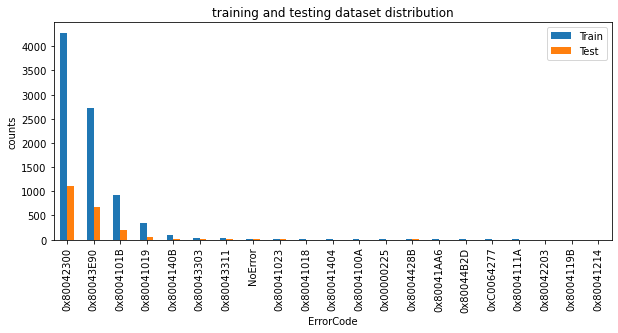

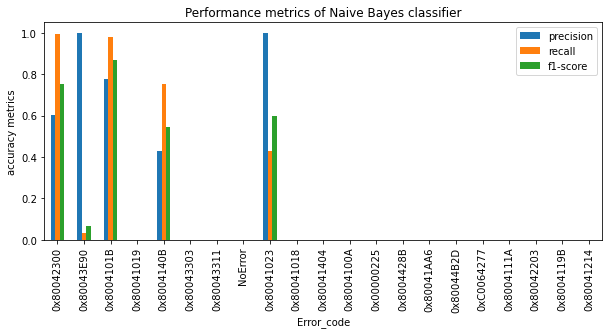

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

accuracy_clf = {}
accuracy_scores = []
classifiers = []

#%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
clf_report = classification_report(y_test, y_pred, output_dict=True)
clf_report_df = pd.DataFrame.from_dict(clf_report).transpose()
clf_report_df.sort_values(by=['support'], ascending=False, inplace=True)
classifiers.append("Naive Bayes")
accuracy_scores.append(accuracy_score(y_pred, y_test))

count_splits.plot(figsize=(10,4), kind='bar')
plt.xlabel('ErrorCode')
plt.ylabel('counts')
plt.title('training and testing dataset distribution')
plt.show()
clf_report_df.loc[count_splits.index].iloc[:,:-1].plot(figsize = (10,4), kind='bar')
plt.xlabel('Error_code')
plt.ylabel('accuracy metrics')
plt.title('Performance metrics of Naive Bayes classifier')
plt.show()

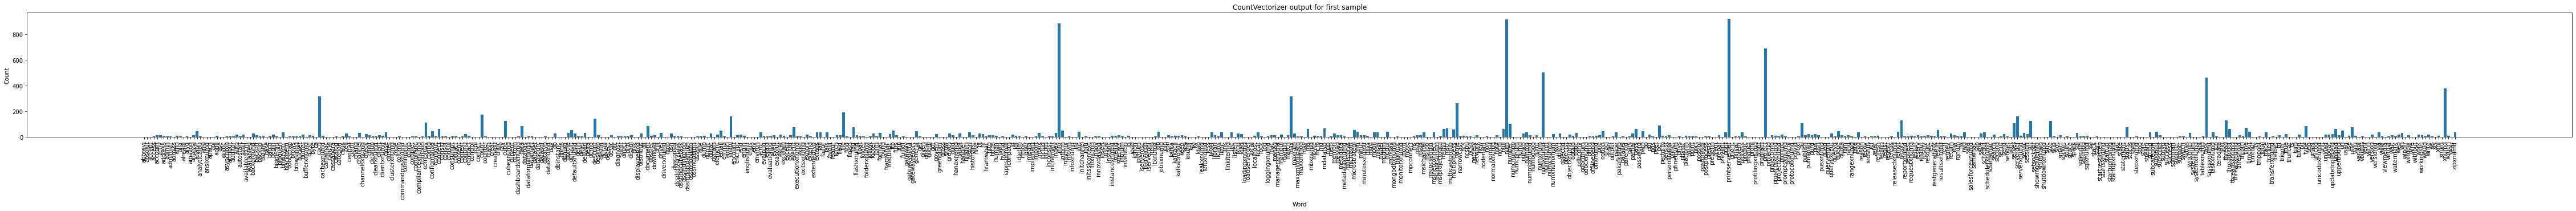

In [19]:
# create a CountVectorizer object
vectorizer = CountVectorizer()

# fit and transform the vectorizer on some sample text data
sample_text = X_test[0]
X = vectorizer.fit_transform(sample_text)

# extract the transformed data for the first sample
sample_data = X[0]

# convert the sparse matrix to a dense array
sample_data = sample_data.toarray()

# get the feature names (i.e., the words in the vocabulary)
feature_names = vectorizer.get_feature_names()

# plot the bar chart of word counts for the first sample
plt.figure(figsize=(80,4))
plt.bar(feature_names, sample_data[0])
plt.xlabel("Word")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("CountVectorizer output for first sample")
plt.show()

In [20]:
countvectorizer_features = pd.DataFrame([feature_names, sample_data[0]]).transpose()
countvectorizer_features.columns = ['features', 'count']
countvectorizer_features.sort_values(by='count', ascending=False)

,features,count
478,printserverdef,920
411,num,914
276,info,881
489,project,686
422,numxnumd,501
...,...,...
184,env,0
451,password,0
185,environ,0
447,parentid,0


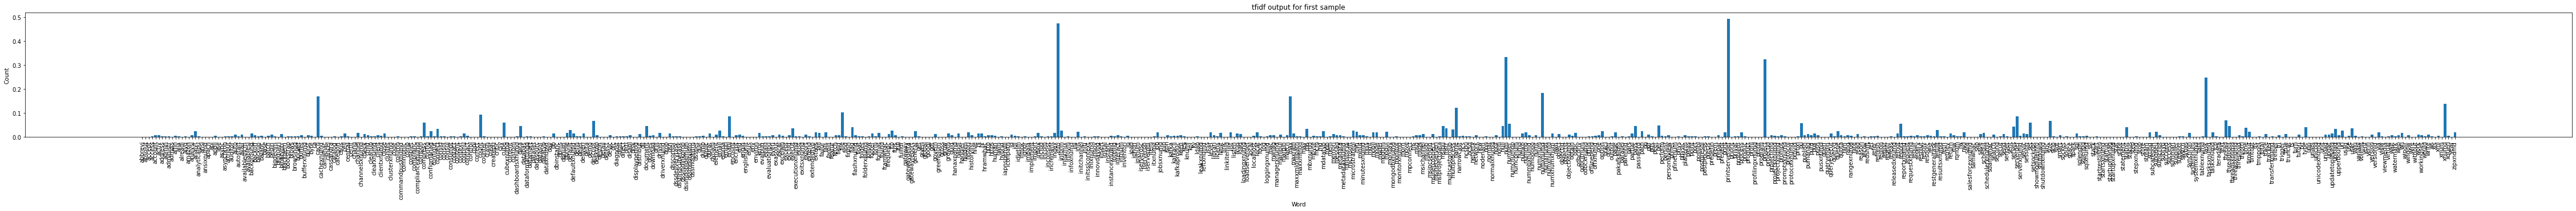

In [21]:
# create a tfidf object
tfidf = TfidfTransformer()
# fit and transform the tfidf on vectorizer output
X = tfidf.fit_transform(X)
# extract the transformed data for the first sample
sample_data = X[0]
# convert the sparse matrix to a dense array
sample_data = sample_data.toarray()
feature_names = vectorizer.get_feature_names()

# plot the bar chart of word counts for the first sample
plt.figure(figsize=(80,4))
plt.bar(feature_names, sample_data[0])
plt.xlabel("Word")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("tfidf output for first sample")
plt.show()


In [22]:
tfidf_features = pd.DataFrame([feature_names, sample_data[0]]).transpose()
tfidf_features.columns = ['features', 'count']
tfidf_features.sort_values(by='count', ascending=False, inplace=True)
tfidf_features[tfidf_features['count'] > 0]

,features,count
478,printserverdef,0.494869
276,info,0.47389
411,num,0.334449
489,project,0.323233
622,task,0.247972
...,...,...
131,defin,0.00062
534,requir,0.00062
284,initi,0.000538
219,follow,0.000538


<u> Closer look on the NB model performance </u>

In [23]:
def get_maxprob_and_label(text, threshold):
    y_pred_prob = nb.predict_proba(text)
    label = nb.classes_[np.argmax(y_pred_prob[0], axis=0)]
    prob = np.max(y_pred_prob[0], axis=0)
    if prob >= threshold:
        return label, prob, 'Error sent to temp@hotmail.com'
    else:
        return 'nan', 0.0, 'NA'
    
def get_info_before_eachtimepoint(time, timedelta):
    timedelta = pd.Timedelta(str(timedelta) + ' minutes')
    message = []
    start_date = time - timedelta
    end_date = time
    chunk = logstash[(logstash.Date > start_date) & (logstash.Date <= end_date)]
    #chunk = chunk.drop_duplicates(subset='Message', keep='first')
    #print(chunk.Message)
    #chunk['Message'] = chunk['Message'].apply(round1)
    message.append(' '.join(chunk['Message']))
    return message


logstash_temp = logstash.iloc[0:1000]
logstash_temp.shape
for index, row in logstash_temp.iterrows():
    text = get_info_before_eachtimepoint(row['Date'], 5)
    label, prob, email = get_maxprob_and_label(text, 0.80)
    print(str(row['Date'])[0:16] + "| ActualError :" + str(row['ErrorCode']) + "| PredictedError :" + str(label)
          + "| Probability :" + str(prob)[0:4] + "| Action: " + str(email))

2023-03-14 09:45| ActualError :0x8004100A| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :0x80041023| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :0x80041023| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :0x80041023| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :0x80041023| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :0x80041023| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :0x80041023| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :0x80041023| PredictedError :nan| Probab

2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.96| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.96| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.96| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.96| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.96| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.96| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.96| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.96| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| Actual

2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| Actual

2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.99| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.99| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.99| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.99| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.99| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.99| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.99| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x8004140B| Probability :0.99| Action: Error sent to temp@hotmail.com
2023-03-14 09:46| Actual

2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| Actual

2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com
2023-03-14 09:47| ActualError :nan| PredictedError :0x8004140B| Probability :0.98| Action: Error sent to temp@hotmail.com


KeyboardInterrupt: 

<u>2. Support vector machines (SVM) classifier</u>

accuracy 0.8437209302325581


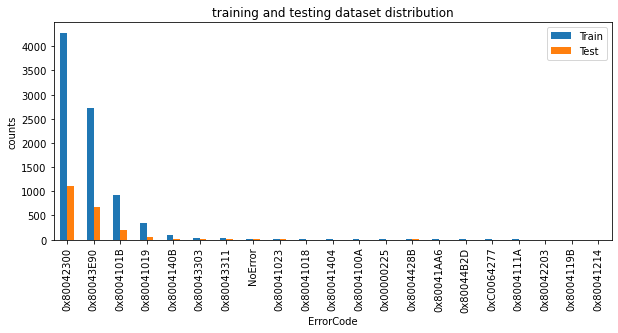

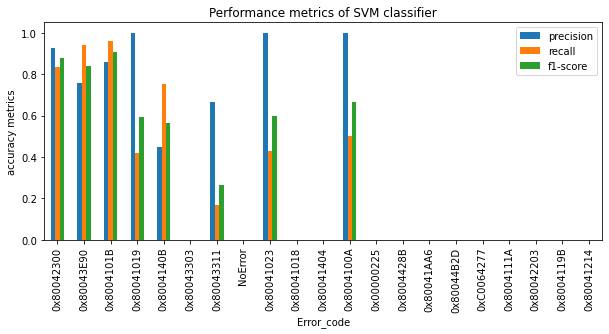

In [24]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])
sgd.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
clf_report = classification_report(y_test, y_pred, output_dict=True)
clf_report_df = pd.DataFrame.from_dict(clf_report).transpose()
clf_report_df.sort_values(by=['support'], ascending=False, inplace=True)
classifiers.append("SVM")
accuracy_scores.append(accuracy_score(y_pred, y_test))

count_splits.plot(figsize=(10,4), kind='bar')
plt.xlabel('ErrorCode')
plt.ylabel('counts')
plt.title('training and testing dataset distribution')
plt.show()
clf_report_df.loc[count_splits.index].iloc[:,:-1].plot(figsize = (10,4), kind='bar')
plt.xlabel('Error_code')
plt.ylabel('accuracy metrics')
plt.title('Performance metrics of SVM classifier')
plt.show()

<u>3. Logistic regression </u>

accuracy 0.9641860465116279


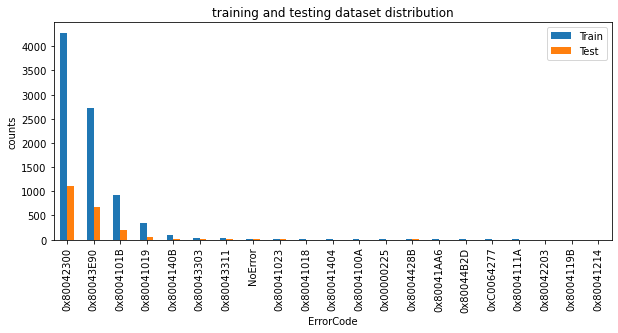

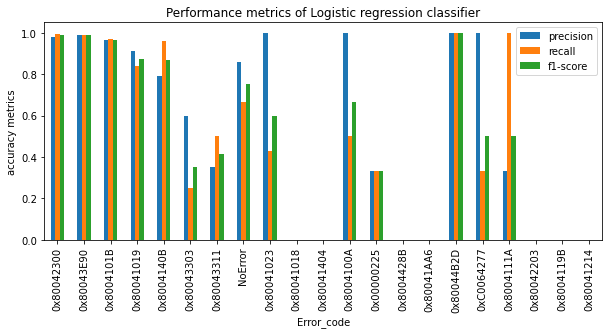

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(n_jobs=1, C=1e5)),
              ])
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

#conf_mat = confusion_matrix(y_test, y_pred)
#print('Confusion matrix:\n', conf_mat)

# Get TP, FP, and FN indices
#precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)
#TP_indices = np.where((y_pred == y_test))[0]
#FP_indices = np.where((y_pred != y_test))[0]
#FN_indices = np.where((y_pred != y_test))[0]

#print('True positives indices:', TP_indices)
#print('False positives indices:', FP_indices)

print('accuracy %s' % accuracy_score(y_pred, y_test))
clf_report = classification_report(y_test, y_pred, output_dict=True)
clf_report_df = pd.DataFrame.from_dict(clf_report).transpose()
clf_report_df.sort_values(by=['support'], ascending=False, inplace=True)
classifiers.append("Logistic Regression")
accuracy_scores.append(accuracy_score(y_pred, y_test))

count_splits.plot(figsize=(10,4), kind='bar')
plt.xlabel('ErrorCode')
plt.ylabel('counts')
plt.title('training and testing dataset distribution')
plt.show()
clf_report_df.loc[count_splits.index].iloc[:,:-1].plot(figsize = (10,4), kind='bar')
plt.xlabel('Error_code')
plt.ylabel('accuracy metrics')
plt.title('Performance metrics of Logistic regression classifier')
plt.show()

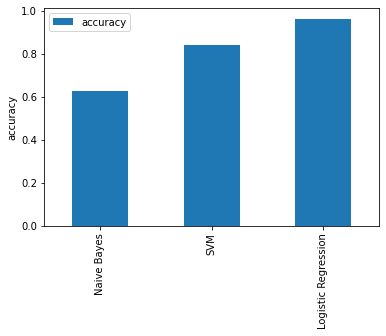

In [26]:
accuracy_clf['classifier'] = classifiers
accuracy_clf['accuracy'] = accuracy_scores
pd.DataFrame.from_dict(accuracy_clf).plot(kind='bar')
plt.xticks([0,1,2], classifiers)
plt.ylabel('accuracy')
plt.show()

<u>closer look on the LR model performance:</u>

* This model can applied every log message that is generated in a log file and generate a trigger warning whenever
  error code is predicted.
* A dummy email so that when an error is triggered, an email will be sent to temp@hotmail.com

In [29]:
def get_maxprob_and_label(text, threshold):
    y_pred_prob = lr.predict_proba(text)
    label = lr.classes_[np.argmax(y_pred_prob[0], axis=0)]
    prob = np.max(y_pred_prob[0], axis=0)
    if prob >= threshold:
        return label, prob, 'error sent to temp@hotmail.com'
    else:
        return 'nan', 0.0, 'NA'
    
def get_info_before_eachtimepoint(time, timedelta):
    timedelta = pd.Timedelta(str(timedelta) + ' minutes')
    message = []
    start_date = time - timedelta
    end_date = time
    chunk = logstash[(logstash.Date > start_date) & (logstash.Date <= end_date)]
    #chunk = chunk.drop_duplicates(subset='Message', keep='first')
    #print(chunk.Message)
    #chunk['Message'] = chunk['Message'].apply(round1)
    message.append(' '.join(chunk['Message']))
    return message


logstash_temp = logstash.iloc[0:1000]
logstash_temp.shape
for index, row in logstash_temp.iterrows():
    text = get_info_before_eachtimepoint(row['Date'], 5)
    label, prob, email = get_maxprob_and_label(text, 0.99)
    print(str(row['Date'])[0:16] + "| ActualError :" + str(row['ErrorCode']) + "| PredictedError :" + str(label)
          + "| Probability :" + str(prob)[0:4] + "| Action: " + str(email))

2023-03-14 09:45| ActualError :0x8004100A| PredictedError :0x8004100A| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :0x8004100A| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :0x8004100A| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:45| ActualError :0x8004100A| PredictedError :0x8004100A| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :0x80041023| PredictedError :0x80041023| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :0x80041023| PredictedError :0x80041023| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :0x80041023| PredictedError :0x80041023| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :0x80041023| PredictedError :0x80041023| Probability :0.99| Action:

2023-03-14 09:46| ActualError :nan| PredictedError :0x80044B2D| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x80044B2D| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x80044B2D| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x80044B2D| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x80044B2D| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x80044B2D| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x80044B2D| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| ActualError :nan| PredictedError :0x80044B2D| Probability :0.99| Action: error sent to temp@hotmail.com
2023-03-14 09:46| Actual

2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:46| ActualError :nan| PredictedError :na

2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :na

2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 09:47| ActualError :nan| PredictedError :na

2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :na

2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :na

2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:06| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:07| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:07| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:07| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:07| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:07| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:07| ActualError :nan| PredictedError :na

2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :na

2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :na

2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :nan| Probability :0.0| Action: NA
2023-03-14 10:10| ActualError :nan| PredictedError :na

<u>Reduce the tendency to overfit on the training data:</u>

* LogisticRegression model with a high value of C (1e5) and n_jobs set to 1, has a higher tendency to overfit on the training data. 
* A high value of C indicates that the model is more flexible and will fit the training data more closely, which can lead to overfitting if the model is not properly regularized.
* To prevent overfitting, it is important to evaluate the model on a holdout set or using cross-validation, and also consider using regularization techniques such as L1 or L2 regularization or adjusting the value of C. 
* Additionally, it may be beneficial to explore other models that are less prone to overfitting, such as Naive Bayes or Support Vector Machines (SVMs).


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Create a pipeline with CountVectorizer, TfidfTransformer, and LogisticRegression
lr_reg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=1))
])

# Define hyperparameters for tuning using GridSearchCV
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
}

# Use stratified k-fold cross-validation for tuning hyperparameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object with the pipeline and hyperparameters
grid_search = GridSearchCV(lr_reg, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Evaluate the best model on the test data
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Test accuracy: {accuracy:.2f}')
print(f'Classification report:\n{report}')


Test accuracy: 0.95
Classification report:
              precision    recall  f1-score   support

  0x00000225       0.00      0.00      0.00         3
  0x8004100A       1.00      0.50      0.67         2
  0x80041018       0.00      0.00      0.00         3
  0x80041019       0.88      0.71      0.79        62
  0x8004101B       0.93      0.97      0.95       210
  0x80041023       0.83      0.71      0.77         7
  0x8004111A       0.00      0.00      0.00         1
  0x8004116F       0.00      0.00      0.00         1
  0x8004119B       0.00      0.00      0.00         2
  0x800411AA       0.00      0.00      0.00         2
  0x80041214       0.00      0.00      0.00         1
  0x80041404       0.00      0.00      0.00         2
  0x8004140B       0.56      0.83      0.67        24
  0x80041AA6       0.00      0.00      0.00         1
  0x80042200       0.00      0.00      0.00         1
  0x80042203       0.00      0.00      0.00         1
  0x80042300       0.98      0.99     

In [ ]:
def get_maxprob_and_label_regularized(text, threshold):
    y_pred_prob = grid_search.predict_proba(text)
    label = grid_search.classes_[np.argmax(y_pred_prob[0], axis=0)]
    prob = np.max(y_pred_prob[0], axis=0)
    if prob >= threshold:
        return label, prob, 'error sent to temp@hotmail.com'
    else:
        return 'nan', 0.0, 'NA'

for index, row in logstash_temp.iterrows():
    text = get_info_before_eachtimepoint(row['Date'], 5)
    label, prob, email = get_maxprob_and_label(text, 0.999)
    print(str(row['Date'])[0:16] + "| ActualError :" + str(row['ErrorCode']) + "| PredictedError :" + str(label)
          + "| Probability :" + str(prob)[0:4] + "| Action: " + str(email))

<u>Further interpretation of the model's output:</u>
* comparison of 5 examples of the training set and testing set

In [ ]:
pd.set_option('display.max_colwidth', None)
class_to_print = "0x80043E90"



def get_info_before_errorcode_byindexlist(error_code, index_list, timedelta):
    timedelta = pd.Timedelta(str(timedelta) + ' minutes')
    
    chunks = []
    error_code_info = {}
    error_code_info['ID'] = class_to_print
    occurance = []
    message = []
    count=0
    for index in index_list:
        start_date = str(logstash.loc[index, 'Date'] - timedelta)
        end_date = str(logstash.loc[index, 'Date'])
        chunk = logstash[(logstash.Date > start_date) & (logstash.Date <= end_date)]
        df = chunk.filter(['Date','ErrorCode'])
        df['chunk_num'] = str(count)
        df['Message'] = chunk.filter(['Message']) 
        count += 1
        chunks.append(df)
    
    result = pd.concat(chunks)
    return result


# Print 5 examples from the training set
print("Training set examples:")
train_set_index = []
train_examples = np.where(y_train == class_to_print)[0][:5]
for example_idx in train_examples:
    print(message_corpus.iloc[example_idx]['logstash_index'])
    train_set_index.append(message_corpus.iloc[example_idx]['logstash_index'])
print(train_set_index) 

test_set_index = []
# Print 5 examples from the testing set
print("\nTesting set examples:")
test_examples = np.where(y_test == class_to_print)[0][:5]
for example_idx in test_examples:
    test_set_index.append(message_corpus.iloc[example_idx]['logstash_index'])

print(test_set_index)


timedelta = 5 #minutes

#chunks = []

with pd.ExcelWriter('Train_Test_set' + str(timedelta) + 'min_Messages.xlsx') as writer:
    df1 = pd.DataFrame.from_dict(get_info_before_errorcode_byindexlist(class_to_print, train_set_index, timedelta))
    df1.to_excel(writer, sheet_name='train_set')
    df2 = pd.DataFrame.from_dict(get_info_before_errorcode_byindexlist(class_to_print, test_set_index, timedelta))
    df2.to_excel(writer, sheet_name='test_set')


In [1]:
logstash['ErrorCode']

NameError: name 'logstash' is not defined